In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Считываем данные**

In [21]:
df = pd.read_csv('data_eda.csv')

**Создаем столбец целевой переменной**

**Если больше медианы выборки 1, если меньше 0**

In [22]:
median_value = df['CC50, mM'].median()

df['class'] = (df['CC50, mM'] > median_value).astype(int)

**Формируем признаки и целевую**

In [24]:
# Должны исключить из признаков саму целевую переменную и SI - рассчитывается на основе параметров IC50 и CC50
X = df.drop(['CC50, mM', 'SI', 'class'], axis=1)
y = df['class']

**Оценим зависимость признаков и целевой переменной с помощью Mutual Info**

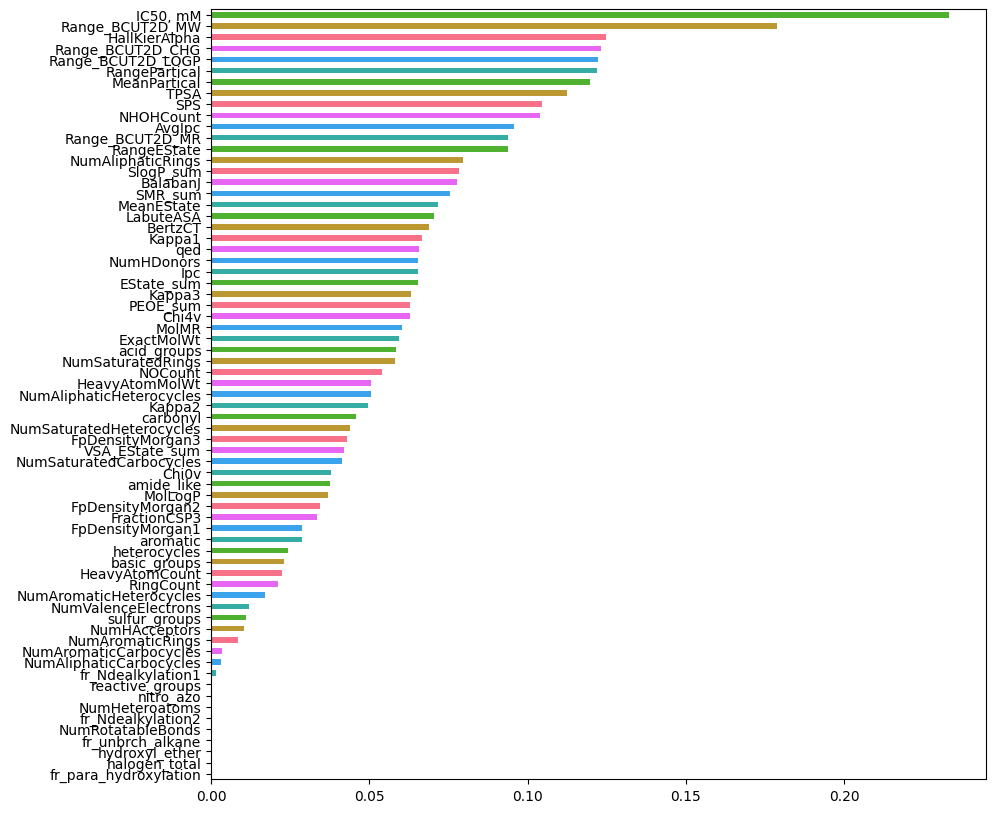

In [25]:
# Изучим зависимость признаков
importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feature_importances = feature_importances.sort_values()

colors = sns.color_palette("husl")
plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh', color=colors)
plt.show()

**Уберем менее значимые признаки**

In [26]:
X.drop(columns=feature_importances.index[0:17], inplace=True)

**Делим данные на тестовые и тренировочные**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% данных в тест, 80% в трейн
    random_state=42,    # для воспроизводимости
    stratify=y         
)

**Стандартизируем данные**

In [28]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)

X_test_scaler = scaler.transform(X_test)

**Создадим DataFrame для сбора всех метрик и дальнейшего анализа**

In [29]:
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

## **Логистическая регрессия**

In [30]:
model = LogisticRegression(max_iter=10000, random_state=42)

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'class_weight': [None, 'balanced']
    }
]

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
)

# Запуск поиска
grid_search.fit(X_train_scaler, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 1, 'class_weight': None, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


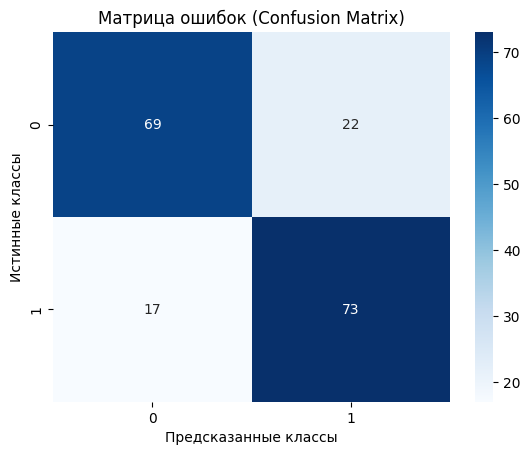

Accuracy: 0.7845
Precision: 0.7684
Recall: 0.8111
F1-score: 0.7892


In [31]:
# Переменная для лучшей модели
best_log = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_log.predict(X_test_scaler)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Сохраним метрики модели
metrics_df.loc[0] = ["LogisticRegression", accuracy, precision, recall, f1]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")  
print(f"Recall: {recall:.4f}")        
print(f"F1-score: {f1:.4f}")          

## **Случайный лес**

In [32]:
# Создание модели
rf = RandomForestClassifier(random_state=42)

# Задаем сетку гиперпараметров для перебора
param_grid = {
    'n_estimators': [50, 100, 200],       # Количество деревьев
    'max_depth': [None, 10, 20, 30],      # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],      # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],        # Минимальное число образцов в листе
    'bootstrap': [True, False],           # Использовать ли бутстрэп для построения деревьев
    'max_features': ['sqrt', 'log2']      # Количество признаков для выбора при разделении
}

# Создаем GridSearchCV объект
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,          
    n_jobs=-1,       
    scoring='roc_auc'  
)

# Запускаем поиск
grid_search.fit(X_train_scaler, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


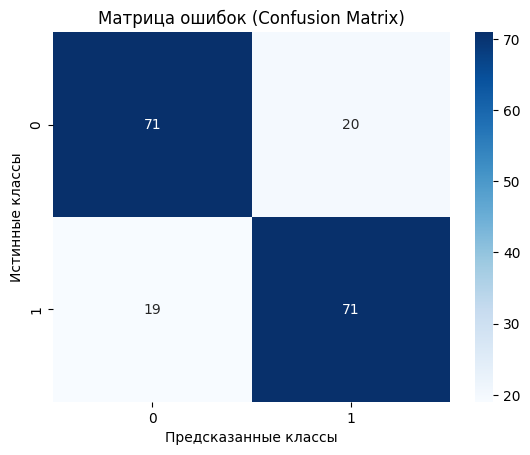

Accuracy: 0.7845
Precision: 0.7802
Recall: 0.7889
F1-score: 0.7845


In [33]:
# Переменная для лучшей модели
best_rf = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_rf.predict(X_test_scaler)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Сохраним метрики модели
metrics_df.loc[1] = ["RandomForestClassifier", accuracy, precision, recall, f1]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")  
print(f"Recall: {recall:.4f}")        
print(f"F1-score: {f1:.4f}")    

## **CatBoost**


In [34]:
catB = CatBoostClassifier(loss_function='Logloss', verbose=False, random_state=42)

param_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

# Создаем GridSearchCV объект
grid_search = GridSearchCV(
    estimator=catB,
    param_grid=param_grid,
    cv=5,          
    n_jobs=-1,       
    scoring='roc_auc'  
)

# Запускаем поиск
grid_search.fit(X_train_scaler, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'border_count': 64, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.05}


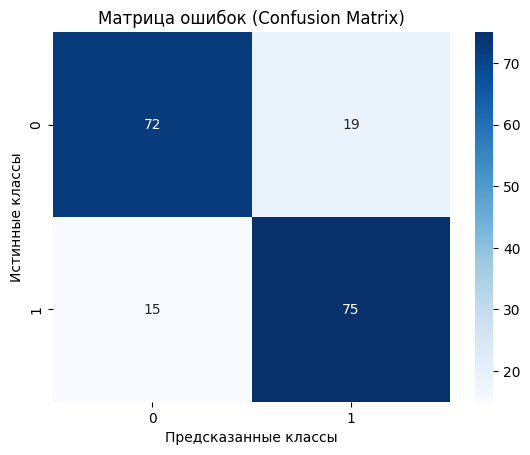

Accuracy: 0.8122
Precision: 0.7979
Recall: 0.8333


In [35]:
# Переменная для лучшей модели
best_catB = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_catB.predict(X_test_scaler)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Сохраним метрики модели
metrics_df.loc[2] = ["CatBoost", accuracy, precision, recall, f1]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")  
print(f"Recall: {recall:.4f}")        

**Посмотрим на метрики всех моделей и выберем лучшую**

In [36]:
metrics_df

,Model,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,0.784530,0.768421,0.811111,0.789189
1,RandomForestClassifier,0.784530,0.780220,0.788889,0.784530
2,CatBoost,0.812155,0.797872,0.833333,0.815217


Модель CatBoost демонстрирует наилучшие результаты по всем ключевым показателям:

* Accuracy (0.812) – выше, чем у LogisticRegression и RandomForest (0.785)
* Precision (0.798) – лучше, чем у других моделей, что означает меньше ложных срабатываний
* Recall (0.833) – выше, чем у конкурентов, что указывает на лучшее выявление положительных классов
* F1-score (0.815) – гармоничное среднее precision и recall, также превосходит остальные модели


> **CatBoost является оптимальным выбором, так как обеспечивает наиболее сбалансированную и высокую производительность!**